How to start the sglang server?
```bash
python3 -m sglang.launch_server --model-path /mnt/nvme0/models/Meta-Llama-3.1-8B-Instruct/ --port 9999 --disable-radix-cache --enable-mixed-chunk --chunked-prefill-size 2048 --disable-overlap-schedule
```
We limited the max-total-token to simulate the memory constraint environment, use disable-radix-cache to shut down the prompt cache.

Profile
```bash
nsys profile --trace-fork-before-exec=true --cuda-graph-trace=node -o sglang.out --delay 60 --duration 70 python3 -m sglang.launch_server --model-path /mnt/nvme0/models/Meta-Llama-3.1-8B-Instruct/ --port 9999 --disable-radix-cache --enable-mixed-chunk --chunked-prefill-size 2048
```

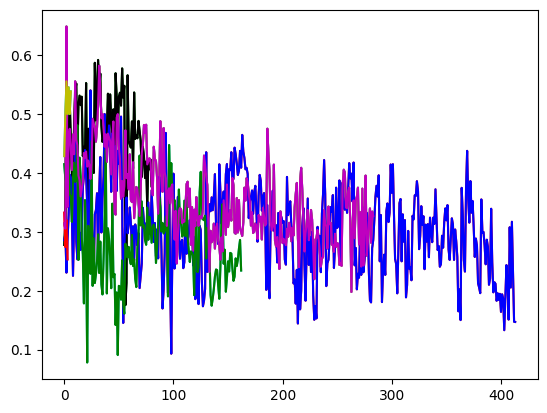

In [4]:
def draw_image_from_file():
    file = open('tmp/attention1.txt', 'r')
    lines = file.readlines()
    x = []
    y = []
    prev_a = -1
    list_idx = -1
    for line in lines:
        _, a, b = line.split(' ')
        a = int(a)
        b = float(b)
        if prev_a == -1 or a - prev_a != 1:
            prev_a = a
            x.append([])
            y.append([])
            list_idx += 1
        x[list_idx].append(a - prev_a)
        y[list_idx].append(b)
        prev_a = a
    # draw a line chart, different color for different x[i]
    import matplotlib.pyplot as plt
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(len(x)):
        # using the accordingly x-axis number
        plt.plot(y[i], color=colors[i % len(colors)])
    plt.show()
    # plt.savefig('tmp/attention1.png')
draw_image_from_file()

In [2]:
import requests
from pprint import pprint

url = "http://localhost:9999/generate"

data = {
    "text": ["What is AI?"],
    "sampling_params": {
        "temperature": 0,
        "max_new_tokens": 32,
    },
}

response = requests.post(url, json=data)
pprint(response.json())

[{'meta_info': {'cached_tokens': 0,
                'completion_tokens': 32,
                'finish_reason': {'length': 32, 'type': 'length'},
                'id': '8850c3c5e6ee40beb4d1b4716214edc1',
                'prompt_tokens': 4},
  'text': ' Artificial Intelligence (AI) is a broad field of computer science '
          'that focuses on creating intelligent machines that can perform '
          'tasks that typically require human intelligence. AI systems can '
          'learn'}]


In [2]:
import os
os.system("~/miniconda3/envs/llm-exp/bin/python -m sglang.bench_serving  \
                                        --port 9999 \
                                        --backend sglang \
                                        --num-prompts 50 \
                                        --dataset-name random \
                                        --dataset-path /mnt/nvme0/chenjunyi/project/sglang/ShareGPT_V3_unfiltered_cleaned_split.json \
                                        --random-input 8192 --random-output 2048")
# os.system("~/miniconda3/envs/llm-exp/bin/python -m sglang.bench_serving  \
#                                         --port 9999 \
#                                         --backend sglang \
#                                         --num-prompts 50 \
#                                         --dataset-name random \
#                                         --dataset-path /mnt/nvme0/chenjunyi/project/sglang/ShareGPT_V3_unfiltered_cleaned_split.json \
#                                         --request-rate-range 1,2,4,8,16,32 --random-range-ratio 0.125 \
#                                         --random-input 8192 --random-output 2048")
# os.system("~/miniconda3/envs/sglang/bin/python benchmark/benchmark_serving.py  \
#                         --port 9999 \
#                         --backend sglang \
#                         --dataset /home/chenjunyi/project/vllm/benchmarks/ShareGPT_V3_unfiltered_cleaned_split.json \
#                         --model /data/chenjunyi/models/qwen2-7b-chat/ \
#                         --num-prompts 50")

Namespace(backend='sglang', base_url=None, host='0.0.0.0', port=9999, dataset_name='random', dataset_path='/mnt/nvme0/chenjunyi/project/sglang/ShareGPT_V3_unfiltered_cleaned_split.json', model='/mnt/nvme0/models/Meta-Llama-3.1-8B-Instruct/', tokenizer=None, num_prompts=50, sharegpt_output_len=None, random_input_len=8192, random_output_len=2048, random_range_ratio=0.0, request_rate=inf, max_concurrency=None, seed=1, multi=False, request_rate_range='2,34,2', output_file=None, disable_tqdm=False, disable_stream=False, disable_ignore_eos=False, return_logprob=False, extra_request_body=None, gen_num_groups=64, gen_prompts_per_group=16, gen_system_prompt_len=2048, gen_question_len=128, gen_output_len=256, profile=False, lora_name=None)

#Input tokens: 207179
#Output tokens: 54472


100%|██████████| 50/50 [00:42<00:00,  1.19it/s]



============ Serving Benchmark Result ============
Backend:                                 sglang    
Traffic request rate:                    inf       
Max reqeuest concurrency:                not set   
Successful requests:                     50        
Benchmark duration (s):                  42.02     
Total input tokens:                      207179    
Total generated tokens:                  54472     
Total generated tokens (retokenized):    54470     
Request throughput (req/s):              1.19      
Input token throughput (tok/s):          4930.12   
Output token throughput (tok/s):         1296.24   
Total token throughput (tok/s):          6226.36   
----------------End-to-End Latency----------------
Mean E2E Latency (ms):                   27030.27  
Median E2E Latency (ms):                 28836.54  
---------------Time to First Token----------------
Mean TTFT (ms):                          7550.40   
Median TTFT (ms):                        3988.72   
P99 TTFT (ms):

0

In [3]:
file = open('tmp/pd_sep_log.txt', 'r')
lines = file.readlines()
decode_reqs_list = []
decode_tokens_list = []
decode_context_tokens_list = []
prefill_reqs_list = []
prefill_tokens_list = []
execute_time_list = []
steps = range(1, len(lines) + 1)
for line in lines:
    # print(f"{decode_reqs} {decode_tokens} {decode_context_tokens} {prefill_reqs} {prefill_tokens}", file=open("output.txt", "a"), end=' ')
    decode_reqs, decode_new_tokens, decode_context_tokens, prefill_reqs, prefill_context_tokens, execute_time = line.split(' ')
    decode_reqs_list.append(int(decode_reqs))
    decode_tokens_list.append(int(decode_new_tokens))
    decode_context_tokens_list.append(int(decode_context_tokens))
    prefill_reqs_list.append(int(prefill_reqs))
    prefill_tokens_list.append(int(prefill_context_tokens))
    execute_time_list.append(float(execute_time))

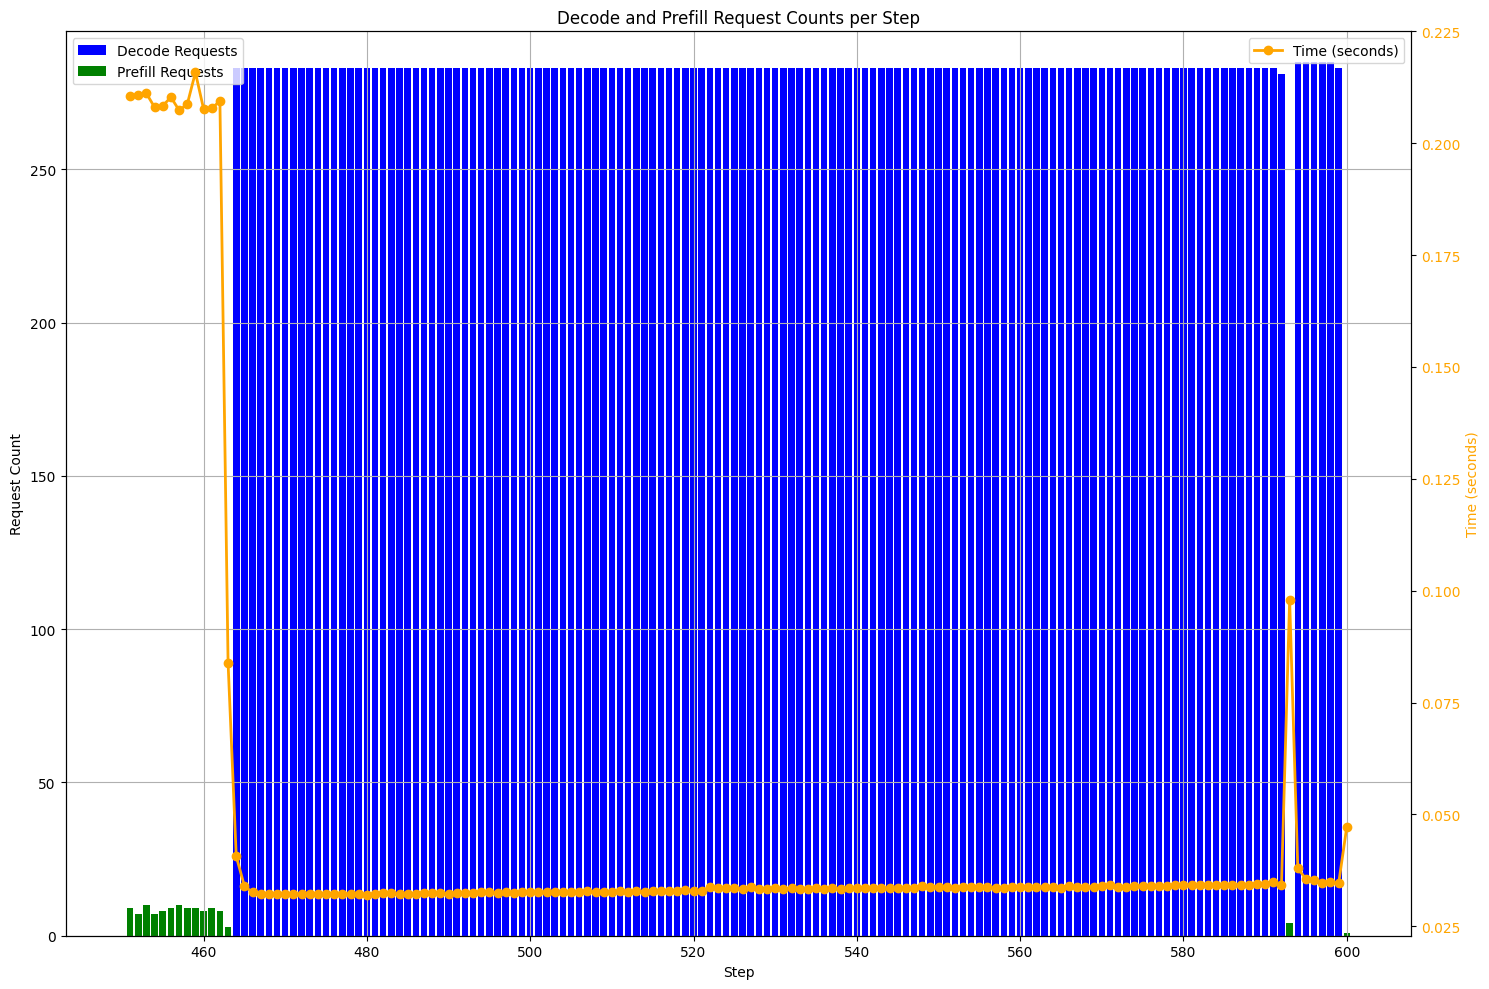

In [26]:
# Draw a chart from output.txt
x=450
y=600
# draw a bar chart, different color for different x[i]
import matplotlib.pyplot as plt
import numpy as np
if x is None:
    x = 0
if y is None:
    y = len(decode_context_tokens_list)
decode_reqs_list_tmp = decode_reqs_list[x:y]
decode_tokens_list_tmp = decode_tokens_list[x:y]
decode_context_tokens_list_tmp = decode_context_tokens_list[x:y]
prefill_reqs_list_tmp = prefill_reqs_list[x:y]
prefill_tokens_list_tmp = prefill_tokens_list[x:y]
execute_time_list_tmp = execute_time_list[x:y]
steps_tmp = steps[x:y]
# 创建画布
fig, ax1 = plt.subplots(figsize=(15, 10))

# 创建堆叠条形图（显示请求数量）
ax1.bar(steps_tmp, decode_reqs_list_tmp, label='Decode Requests', color='blue')  # 解码请求，用蓝色表示
ax1.bar(steps_tmp, prefill_reqs_list_tmp, label='Prefill Requests', bottom=decode_reqs_list_tmp, color='green')  # 预填充请求，用绿色表示，并叠加在解码请求上

# 设置左侧 Y 轴标签和标题
ax1.set_xlabel('Step')  # X轴标签
ax1.set_ylabel('Request Count')  # Y轴标签（左侧）
ax1.set_title('Decode and Prefill Request Counts per Step')  # 图表标题
ax1.grid(True)
ax1.set_ylim(0, np.max(decode_reqs_list_tmp + prefill_reqs_list_tmp) + 10)

# 创建右侧 Y 轴（显示时间）
ax2 = ax1.twinx()
ax2.plot(steps_tmp, execute_time_list_tmp, color='orange', marker='o', label='Time (seconds)', linestyle='-', linewidth=2)  # 时间折线图，用橙色表示

# 设置右侧 Y 轴标签
ax2.set_ylabel('Time (seconds)', color='orange')  # Y轴标签（右侧）
ax2.tick_params(axis='y', labelcolor='orange')  # 设置右侧 Y 轴标签颜色为橙色

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 调整布局避免遮挡
plt.tight_layout()

# 显示图表
plt.show()

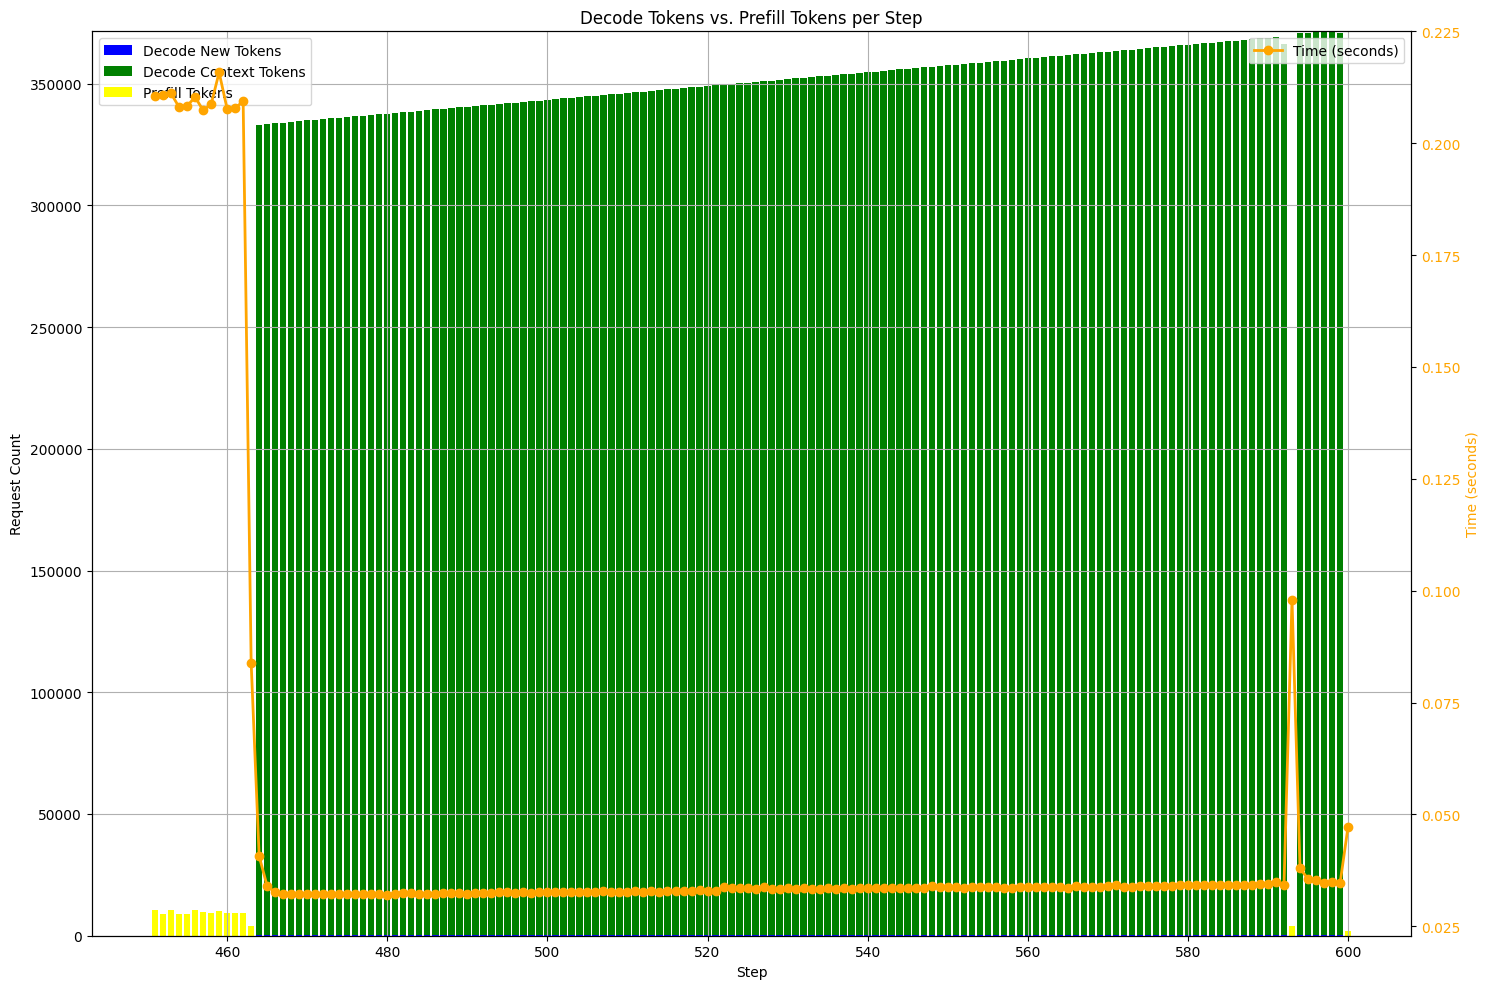

In [27]:
# Draw a chart from output.txt
x=450
y=600
# draw a bar chart, different color for different x[i]
import matplotlib.pyplot as plt
import numpy as np
if x is None:
    x = 0
if y is None:
    y = len(decode_context_tokens_list)
decode_reqs_list_tmp = decode_reqs_list[x:y]
decode_tokens_list_tmp = decode_tokens_list[x:y]
decode_context_tokens_list_tmp = decode_context_tokens_list[x:y]
prefill_reqs_list_tmp = prefill_reqs_list[x:y]
prefill_tokens_list_tmp = prefill_tokens_list[x:y]
execute_time_list_tmp = execute_time_list[x:y]
steps_tmp = steps[x:y]
# 创建画布
fig, ax1 = plt.subplots(figsize=(15, 10))

# 创建堆叠条形图（显示请求数量）
ax1.bar(steps_tmp, decode_tokens_list_tmp, label='Decode New Tokens', color='blue')  # 解码请求，用蓝色表示
ax1.bar(steps_tmp, decode_context_tokens_list_tmp, label='Decode Context Tokens', bottom=decode_tokens_list_tmp, color='green')  # 预填充请求，用绿色表示，并叠加在解码请求上
ax1.bar(steps_tmp, prefill_tokens_list_tmp, label='Prefill Tokens', bottom=decode_context_tokens_list_tmp, color='yellow')

# 设置左侧 Y 轴标签和标题
ax1.set_xlabel('Step')  # X轴标签
ax1.set_ylabel('Request Count')  # Y轴标签（左侧）
ax1.set_title('Decode Tokens vs. Prefill Tokens per Step')  # 图表标题
ax1.grid(True)
ax1.set_ylim(0, np.max(decode_tokens_list_tmp + decode_context_tokens_list_tmp + prefill_tokens_list_tmp) + 10)

# 创建右侧 Y 轴（显示时间）
ax2 = ax1.twinx()
ax2.plot(steps_tmp, execute_time_list_tmp, color='orange', marker='o', label='Time (seconds)', linestyle='-', linewidth=2)  # 时间折线图，用橙色表示

# 设置右侧 Y 轴标签
ax2.set_ylabel('Time (seconds)', color='orange')  # Y轴标签（右侧）
ax2.tick_params(axis='y', labelcolor='orange')  # 设置右侧 Y 轴标签颜色为橙色

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 调整布局避免遮挡
plt.tight_layout()

# 显示图表
plt.show()

In [16]:
file = open('tmp/output.txt', 'r')
lines = file.readlines()
decode_reqs_list = []
prefill_reqs_list = []
context_token_list = []
extend_token_list = []
execute_time_list = []
steps = range(1, len(lines) + 1)
for line in lines:
    # print(f"{decode_reqs} {decode_tokens} {decode_context_tokens} {prefill_reqs} {prefill_tokens}", file=open("output.txt", "a"), end=' ')
    decode_reqs, prefill_reqs, context_token, extend_token, execute_time = line.split(' ')
    decode_reqs_list.append(int(decode_reqs))
    prefill_reqs_list.append(int(prefill_reqs))
    context_token_list.append(int(context_token))
    extend_token_list.append(int(extend_token))
    execute_time_list.append(float(execute_time))

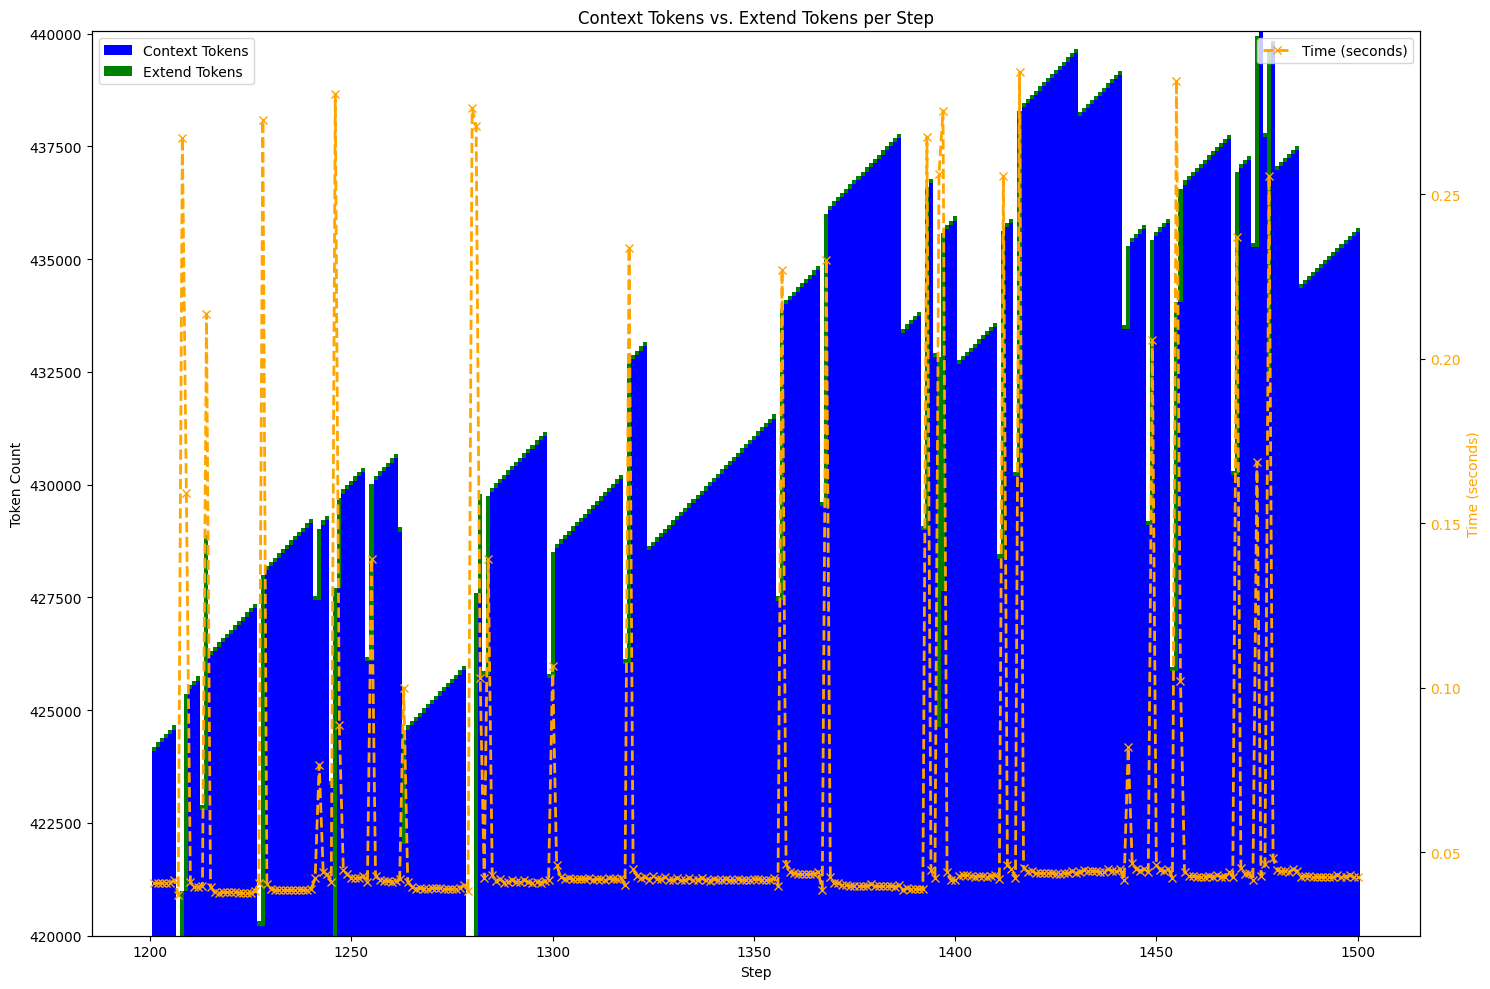

In [49]:
# Draw a chart from output.txt
x=1200
y=1500
# draw a bar chart, different color for different x[i]
import matplotlib.pyplot as plt
import numpy as np
if x is None:
    x = 0
if y is None:
    y = len(decode_reqs_list)
decode_reqs_list_tmp = decode_reqs_list[x:y]
prefill_reqs_list_tmp = prefill_reqs_list[x:y]
context_token_list_tmp = context_token_list[x:y]
extend_token_list_tmp = extend_token_list[x:y]
execute_time_list_tmp = execute_time_list[x:y]
steps_tmp = steps[x:y]
# 创建画布
fig, ax1 = plt.subplots(figsize=(15, 10))
bar_width = 1.0

# 创建堆叠条形图（显示请求数量）
ax1.bar(steps_tmp, context_token_list_tmp, label='Context Tokens', width=bar_width, color='blue')  # 解码请求，用蓝色表示
ax1.bar(steps_tmp, extend_token_list_tmp, label='Extend Tokens', width=bar_width, bottom=context_token_list_tmp, color='green')  # 预填充请求，用绿色表示，并叠加在解码请求上

# 设置左侧 Y 轴标签和标题
ax1.set_xlabel('Step')  # X轴标签
ax1.set_ylabel('Token Count')  # Y轴标签（左侧）
ax1.set_title('Context Tokens vs. Extend Tokens per Step')  # 图表标题
# ax1.grid(True)
ax1.set_ylim(420000, np.max(context_token_list_tmp + extend_token_list_tmp) + 10)

# 创建右侧 Y 轴（显示时间）
ax2 = ax1.twinx()
ax2.plot(steps_tmp, execute_time_list_tmp, color='orange', marker='x', label='Time (seconds)', linestyle='--', linewidth=2)  # 时间折线图，用橙色表示

# 设置右侧 Y 轴标签
ax2.set_ylabel('Time (seconds)', color='orange')  # Y轴标签（右侧）
ax2.tick_params(axis='y', labelcolor='orange')  # 设置右侧 Y 轴标签颜色为橙色

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 调整布局避免遮挡
plt.tight_layout()

# 显示图表
plt.show()

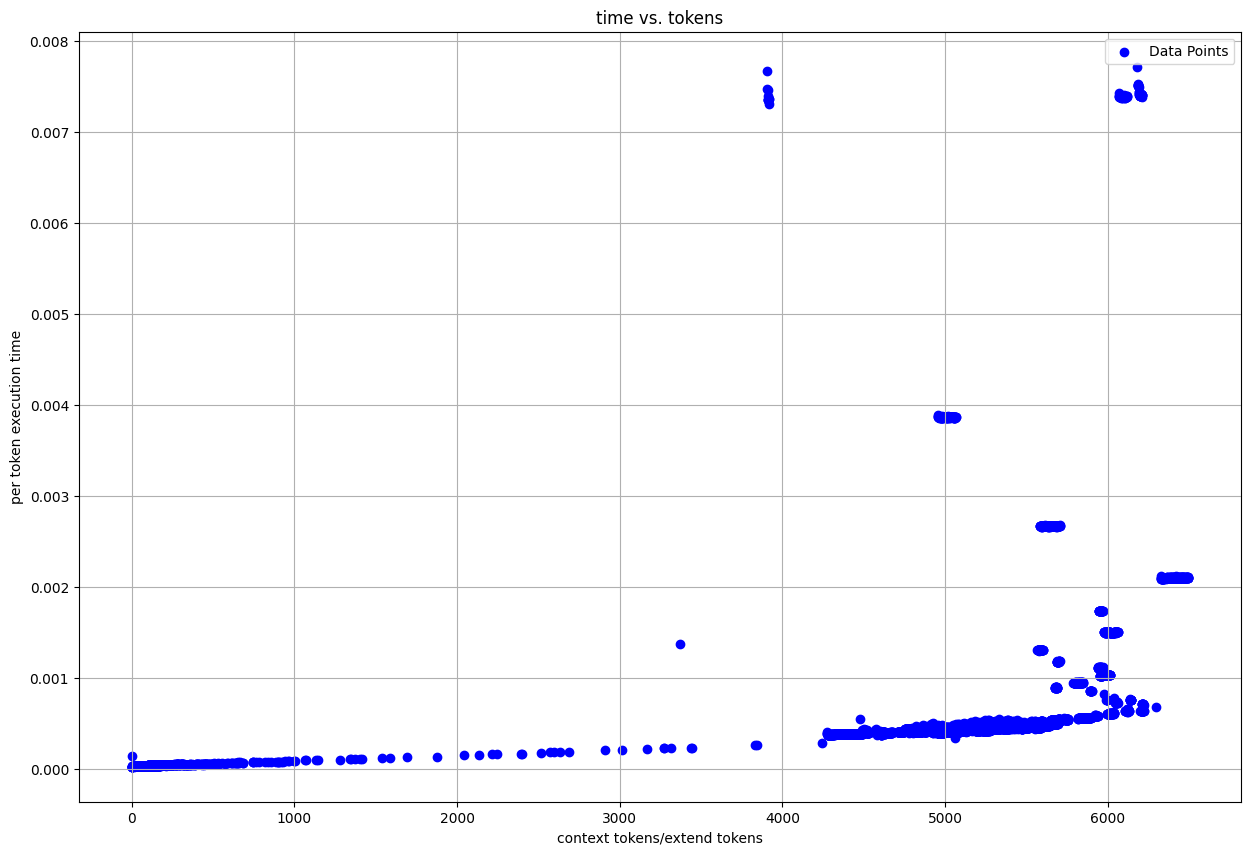

In [17]:
# draw the 2d ploted graph of the time vs context tokens/extend tokens
import matplotlib.pyplot as plt
import numpy as np
fig, ax1 = plt.subplots(figsize=(15, 10))
context_tokens_over_extend_tokens = [context_token_list[i] / extend_token_list[i] for i in range(len(context_token_list))]
execute_time_list_per_token = [execute_time_list[i] / extend_token_list[i] for i in range(len(context_token_list))]
# 创建散点图
plt.scatter(context_tokens_over_extend_tokens, execute_time_list_per_token, color='blue', marker='o', label='Data Points')

# 添加标题和标签
plt.title('time vs. tokens')  # 标题
plt.xlabel('context tokens/extend tokens')  # x轴标签
plt.ylabel('per token execution time')  # y轴标签

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)


In [1]:
import random
import matplotlib.pyplot as plt

prefill = {}
decode = {}

prefill_tot_time = {}
decode_tot_time = {}

file = open('tmp/batch_detail.txt', 'r')

while True:
    line1 = file.readline()
    line2 = file.readline()
    line3 = file.readline()
    if not line1 and not line2 and not line3:
        break
    prefill_batch_idx = line1.split(' ')
    decode_batch_idx = line2.split(' ')
    time = float(line3.split(' ')[0])
    total_time = float(line3.split(' ')[1])
    for idx in prefill_batch_idx:
        if idx != '\n':
            if idx not in prefill:
                prefill[idx] = []
                prefill_tot_time[idx] = []
            prefill[idx].append(time)
            prefill_tot_time[idx].append(total_time)
    for idx in decode_batch_idx:
        if idx != '\n':
            if idx not in decode:
                decode[idx] = []
                decode_tot_time[idx] = []
            decode[idx].append(time)
            decode_tot_time[idx].append(total_time)

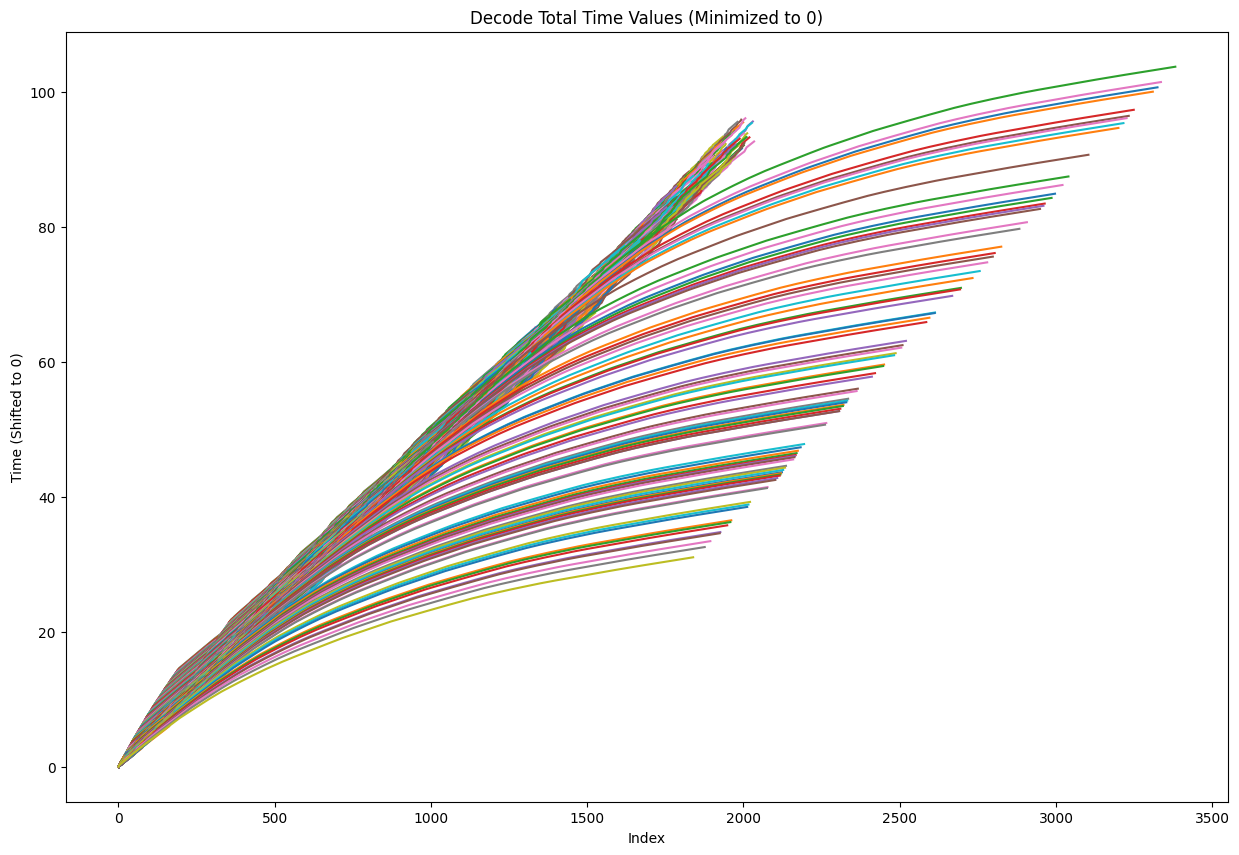

In [2]:
# draw the line graph of a random request
import matplotlib.pyplot as plt
import random
# find the longest prefill values
# Plotting the normalized data from all groups

# Plotting the data with each group normalized such that the minimum is 0
plt.figure(figsize=(15, 10))

# Iterate through each group in `decode_tot_time`
for idx in decode_tot_time:
    # Normalize the data by subtracting the minimum value
    data = decode_tot_time[idx]
    min_val = min(data)
    normalized_data = [x - min_val for x in data]  # Subtract the minimum value to make the minimum zero
    
    # Plot the normalized data
    plt.plot(normalized_data, label=f'Decode {idx}')

# Adding labels, title, and legend
plt.title('Decode Total Time Values (Minimized to 0)')
plt.xlabel('Index')
plt.ylabel('Time (Shifted to 0)')

# Show the plot
plt.show()

750


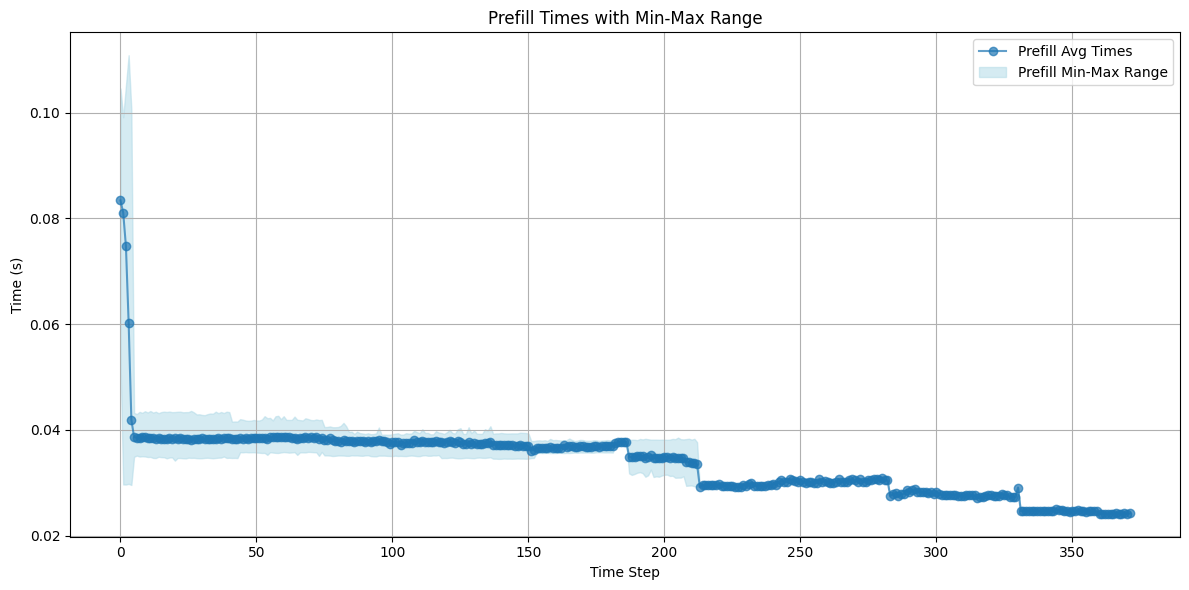

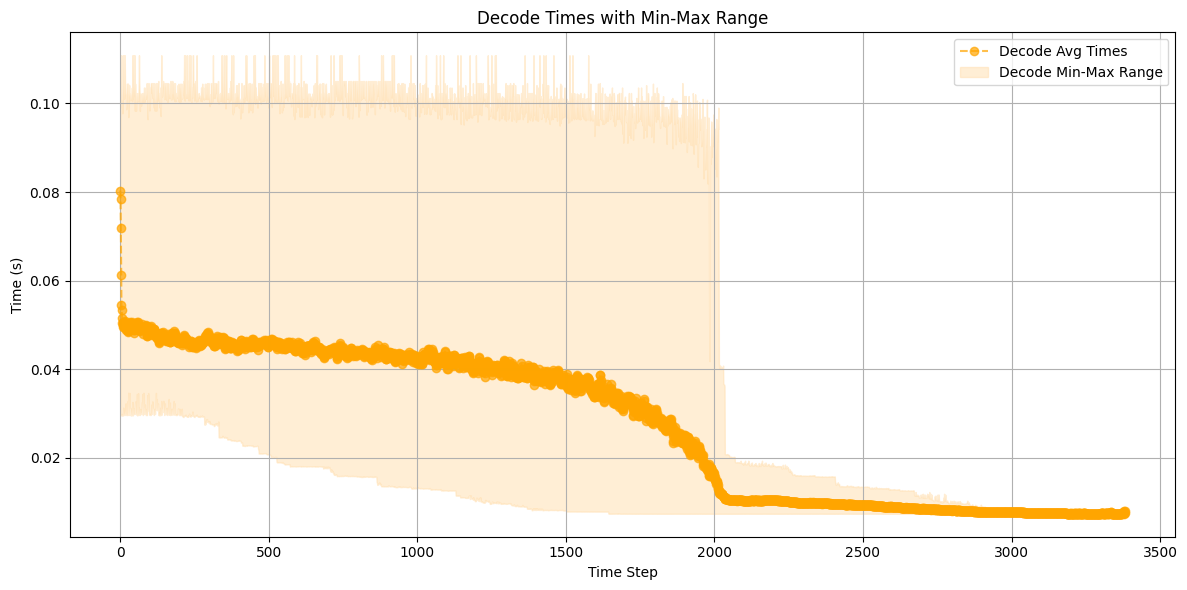

In [ ]:
# 初始化 prefill 和 decode 的时间序列
prefill_avg_times, prefill_min_times, prefill_max_times = [], [], []
decode_avg_times, decode_min_times, decode_max_times = [], [], []

# 计算 prefill 的平均值、最小值和最大值
max_prefill_steps = max(len(values) for values in prefill.values())
print(len(prefill.keys()))
for t in range(max_prefill_steps):
    prefill_times_at_t = [values[t] for values in prefill.values() if t < len(values)]
    if prefill_times_at_t:
        prefill_avg_times.append(sum(prefill_times_at_t) / len(prefill_times_at_t))
        prefill_min_times.append(min(prefill_times_at_t))
        prefill_max_times.append(max(prefill_times_at_t))
    else:
        prefill_avg_times.append(None)
        prefill_min_times.append(None)
        prefill_max_times.append(None)

# 计算 decode 的平均值、最小值和最大值
max_decode_steps = max(len(values) for values in decode.values())
for t in range(max_decode_steps):
    decode_times_at_t = [values[t] for values in decode.values() if t < len(values)]
    if decode_times_at_t:
        decode_avg_times.append(sum(decode_times_at_t) / len(decode_times_at_t))
        decode_min_times.append(min(decode_times_at_t))
        decode_max_times.append(max(decode_times_at_t))
    else:
        decode_avg_times.append(None)
        decode_min_times.append(None)
        decode_max_times.append(None)

# 绘制 Prefill 图表
plt.figure(figsize=(12, 6))
time_steps_prefill = range(max_prefill_steps)
plt.plot(
    time_steps_prefill,
    [t if t is not None else 0 for t in prefill_avg_times],
    label="Prefill Avg Times",
    marker="o",
    linestyle="-",
    alpha=0.7,
)
plt.fill_between(
    time_steps_prefill,
    [t if t is not None else 0 for t in prefill_min_times],
    [t if t is not None else 0 for t in prefill_max_times],
    color="lightblue",
    alpha=0.5,
    label="Prefill Min-Max Range",
)
plt.xlabel("Time Step")
plt.ylabel("Time (s)")
plt.title("Prefill Times with Min-Max Range")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 绘制 Decode 图表
plt.figure(figsize=(12, 6))
time_steps_decode = range(max_decode_steps)
plt.plot(
    time_steps_decode,
    [t if t is not None else 0 for t in decode_avg_times],
    label="Decode Avg Times",
    marker="o",
    linestyle="--",
    alpha=0.7,
    color="orange",
)
plt.fill_between(
    time_steps_decode,
    [t if t is not None else 0 for t in decode_min_times],
    [t if t is not None else 0 for t in decode_max_times],
    color="navajowhite",
    alpha=0.5,
    label="Decode Min-Max Range",
)
plt.xlabel("Time Step")
plt.ylabel("Time (s)")
plt.title("Decode Times with Min-Max Range")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Release rate 10: Total Violation Time = 0.00 units
Release rate 11: Total Violation Time = 0.00 units
Release rate 12: Total Violation Time = 0.00 units
Release rate 13: Total Violation Time = 0.27 units
Release rate 14: Total Violation Time = 0.61 units
Release rate 15: Total Violation Time = 0.86 units
Release rate 16: Total Violation Time = 0.98 units
Release rate 17: Total Violation Time = 1.77 units
Release rate 18: Total Violation Time = 3.91 units
Release rate 19: Total Violation Time = 5.35 units
Release rate 20: Total Violation Time = 6.31 units
Release rate 21: Total Violation Time = 11.46 units
Release rate 22: Total Violation Time = 18.08 units
Release rate 23: Total Violation Time = 21.34 units
Release rate 24: Total Violation Time = 24.24 units
Release rate 25: Total Violation Time = 26.65 units
Release rate 26: Total Violation Time = 28.39 units
Release rate 27: Total Violation Time = 30.00 units
Release rate 28: Total Violation Time = 31.36 units
Release rate 29: Total 

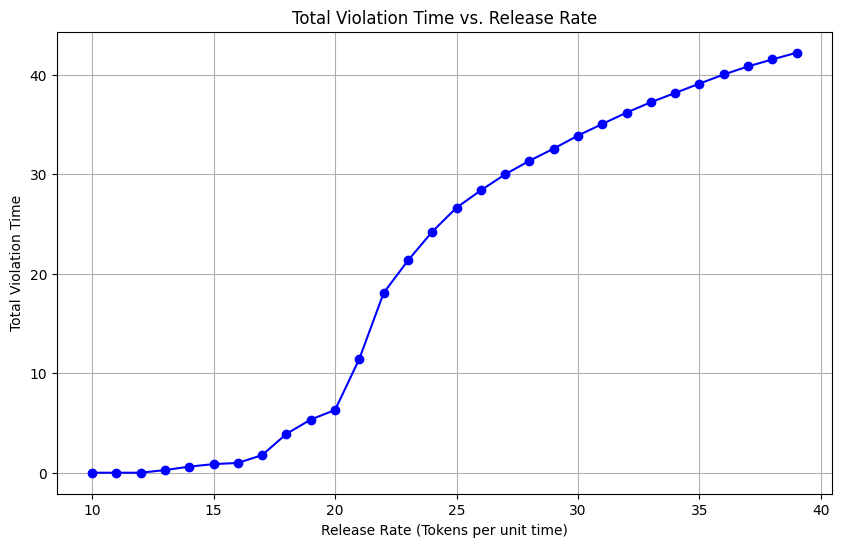

In [ ]:
# We random select a  prefill & decode pair data
import random
random_idx = random.choice(list(prefill.keys()))
prefill_times = prefill[random_idx]
decode_times = [(x - min(decode_tot_time[random_idx])) for x in decode_tot_time[random_idx]]

buffer_capacity = 100  # 缓冲池容量
release_rates = range(10, 40)  # 不同的放水速率
violation_times = {r: 0 for r in release_rates}  # 记录不同放水速率下违反SLO的次数

# 模拟过程
for release_rate in release_rates:
    buffer = 0  # 初始缓冲池为空
    last_time = 0  # 上次事件发生的时间
    violation_start_time = None  # 违反SLO开始的时间
    total_violation_time = 0  # 记录违反SLO的总时间

    for decode_time in decode_times:
        # 计算时间间隔
        time_diff = decode_time - last_time
        last_time = decode_time

        # 放水并增加新的解码事件
        buffer = buffer - release_rate * time_diff  # 放水
        buffer += 1  # 新解码的Token加入缓冲池

        # 如果缓冲池中的Token少于0，说明违反SLO
        if buffer < 0:
            if violation_start_time is None:
                violation_start_time = decode_time  # 记录违反SLO的开始时间
        else:
            if violation_start_time is not None:
                total_violation_time += decode_time - violation_start_time  # 计算这段时间违反的时长
                violation_start_time = None  # 重置违反开始时间

    # 如果最后缓冲池还在违反SLO，计算最后一段时间
    if violation_start_time is not None:
        total_violation_time += decode_times[-1] - violation_start_time

    violation_times[release_rate] = total_violation_time

# 打印结果
for release_rate, violation_time in violation_times.items():
    print(f"Release rate {release_rate}: Total Violation Time = {violation_time:.2f} units")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(release_rates, list(violation_times.values()), marker='o', linestyle='-', color='b')
plt.title('Total Violation Time vs. Release Rate')
plt.xlabel('Release Rate (Tokens per unit time)')
plt.ylabel('Total Violation Time')
plt.grid(True)
plt.show()

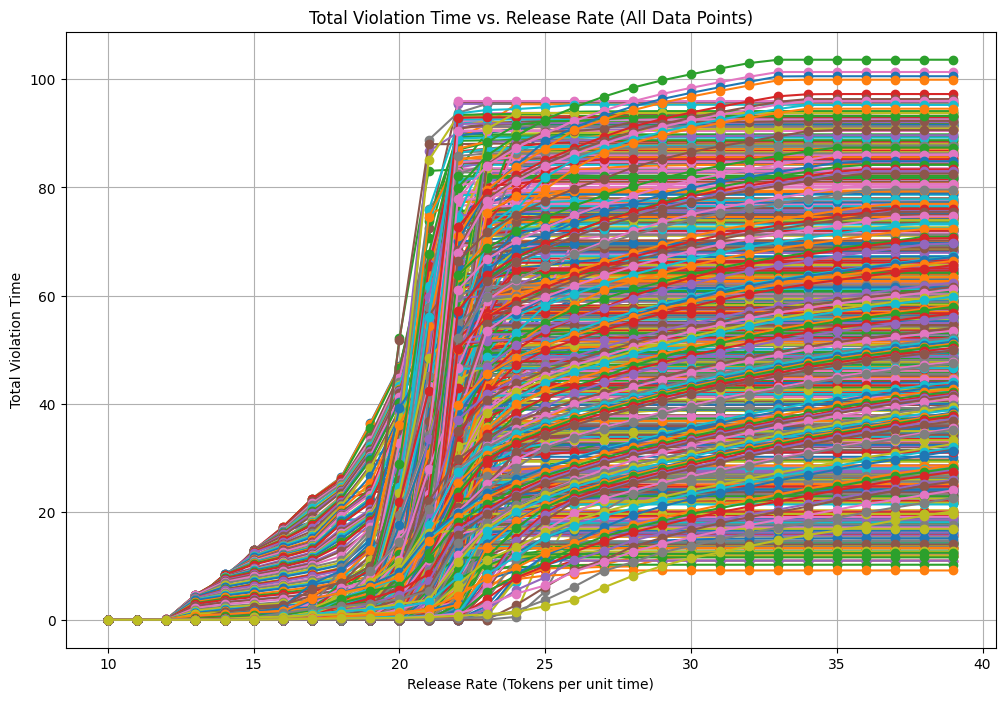

In [5]:
import matplotlib.pyplot as plt

# 假设 prefill 和 decode_tot_time 已经加载，模拟结构如下：
# prefill = {idx: [prefill_time1, prefill_time2, ...]}
# decode_tot_time = {idx: [decode_time1, decode_time2, ...]}

buffer_capacity = 100  # 缓冲池容量
release_rates = range(10, 40)  # 不同的放水速率

# 记录所有数据点在不同放水速率下的总违反时间
all_violation_times = {}

# 遍历每个 prefill & decode 数据点
for random_idx in decode.keys():
    # prefill_times = prefill[random_idx]
    decode_times = [(x - min(decode_tot_time[random_idx])) for x in decode_tot_time[random_idx]]

    violation_times = {r: 0 for r in release_rates}  # 记录不同放水速率下违反SLO的次数

    # 模拟过程
    for release_rate in release_rates:
        buffer = 0  # 初始缓冲池为空
        last_time = 0  # 上次事件发生的时间
        violation_start_time = None  # 违反SLO开始的时间
        total_violation_time = 0  # 记录违反SLO的总时间

        for decode_time in decode_times:
            # 计算时间间隔
            time_diff = decode_time - last_time
            last_time = decode_time

            # 放水并增加新的解码事件
            buffer = buffer - release_rate * time_diff  # 放水
            buffer += 1  # 新解码的Token加入缓冲池

            # 如果缓冲池中的Token少于0，说明违反SLO
            if buffer < 0:
                if violation_start_time is None:
                    violation_start_time = decode_time  # 记录违反SLO的开始时间
            else:
                if violation_start_time is not None:
                    total_violation_time += decode_time - violation_start_time  # 计算这段时间违反的时长
                    violation_start_time = None  # 重置违反开始时间

        # 如果最后缓冲池还在违反SLO，计算最后一段时间
        if violation_start_time is not None:
            total_violation_time += decode_times[-1] - violation_start_time

        violation_times[release_rate] = total_violation_time

    all_violation_times[random_idx] = violation_times

# 可视化结果
plt.figure(figsize=(12, 8))
for random_idx, violation_times in all_violation_times.items():
    plt.plot(release_rates, list(violation_times.values()), marker='o', linestyle='-', label=f'Data Point {random_idx}')

plt.title('Total Violation Time vs. Release Rate (All Data Points)')
plt.xlabel('Release Rate (Tokens per unit time)')
plt.ylabel('Total Violation Time')
# plt.legend()
plt.grid(True)
plt.show()


In [2]:
print(prefill)

{'ebc92c105adf4c059ae6e2254999ea3b': [0.06149888038635254, 0.06424641609191895, 0.03325462341308594], 'e71bd5a156e74000885bdcfd487c736e': [0.05543065071105957, 0.05671334266662598], '8ad564e5ce594209a64b7536fb702a2b': [0.05671334266662598, 0.060347795486450195, 0.06646013259887695, 0.0608673095703125], '580be6f1e0f54846aba7cc9d3edcf05f': [0.0608673095703125, 0.059343814849853516], '08ce1fcb02de4014b300adf79fb8d638': [0.059343814849853516, 0.06250596046447754, 0.06841874122619629, 0.0749809741973877, 0.06029224395751953], '4fdb81d11b5c496298e8394a9e907160': [0.06029224395751953], '8ab6693fca194b56abcc871a57c25725': [0.06029224395751953, 0.06204581260681152, 0.06881952285766602, 0.06181740760803223], 'bbfbbb8d642d4e6c971ad333d57f8fe9': [0.06181740760803223, 0.0653681755065918, 0.0699155330657959, 0.06163382530212402], '7466fd0c699a4a6e89619c3e84d90f51': [0.06163382530212402, 0.06647038459777832, 0.07134366035461426, 0.07464194297790527], 'fd9a0a5044b84d6c8410415f8eac8a08': [0.07464194297